In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/dsire_rps_summary.csv')

# Helper function to safely extract percentage values from strings
def extract_percentage(val):
    if isinstance(val, str) and '%' in val:
        try:
            return float(val.replace('%', '').strip())
        except:
            return None
    return None  # exclude non-percentage entries or MW values

# Clean percentage fields
df['Target'] = df['Target'].apply(extract_percentage)
df['Clean_Energy_Target'] = df['Clean_Energy_Target'].apply(extract_percentage)

# ✅ Filter only by RPS target year (2000–2019), keep all Clean_Energy_Year values
df = df[(df['Year'] >= 2000) & (df['Year'] <= 2019)].copy()

# Feature Engineering: Binary indicators for policy presence
df['has_rps'] = df['Target'].notna().astype(int)
df['has_clean_energy_target'] = df['Clean_Energy_Target'].notna().astype(int)

# Feature Engineering: Policy durations from baseline year (2010)
df['rps_target_duration'] = df['Year'] - 2010
df['clean_energy_duration'] = df['Clean_Energy_Year'] - 2010

# Handle missing durations (fill with 0)
df['rps_target_duration'] = df['rps_target_duration'].fillna(0)
df['clean_energy_duration'] = df['clean_energy_duration'].fillna(0)

# Optional: Reorder columns for readability
df = df[[
    'State', 'Target', 'Year', 'rps_target_duration', 'has_rps',
    'Clean_Energy_Target', 'Clean_Energy_Year', 'clean_energy_duration', 'has_clean_energy_target'
]]

# Output the cleaned DataFrame (optional save to CSV)
print(df.head())
# df.to_csv("cleaned_dsire_rps.csv", index=False)


   State  Target    Year  rps_target_duration  has_rps  Clean_Energy_Target  \
6     ND    10.0  2015.0                  5.0        1                  NaN   
10    OK    15.0  2015.0                  5.0        1                  NaN   
13    WI    10.0  2015.0                  5.0        1                100.0   
23    SD    10.0  2015.0                  5.0        1                  NaN   
25   NMI    20.0  2016.0                  6.0        1                  NaN   

    Clean_Energy_Year  clean_energy_duration  has_clean_energy_target  
6                 NaN                    0.0                        0  
10                NaN                    0.0                        0  
13             2050.0                   40.0                        1  
23                NaN                    0.0                        0  
25                NaN                    0.0                        0  
   State  Target    Year  rps_target_duration  has_rps  Clean_Energy_Target  \
6     ND    10

In [ ]:
import pandas as pd

# === Load Data ===
energy_df = pd.read_csv("/use_all_btu.csv")

# === Melt the wide format to long format (years as rows) ===
value_vars = [col for col in energy_df.columns if col.isdigit()]
melted = pd.melt(
    energy_df,
    id_vars=["MSN", "State"],
    value_vars=value_vars,
    var_name="Year",
    value_name="Data"
)

# === Convert data types ===
melted["Year"] = melted["Year"].astype(int)
melted["Data"] = pd.to_numeric(melted["Data"], errors="coerce")

# === Define prefixes ===
fossil_prefixes = {"NG", "CL", "CO", "PA", "PC", "DF", "JF", "FF"}
renewable_prefixes = {"HY", "WD", "WS", "SO", "GE", "WY"}

# === Filter for relevant MSN codes and classify energy types ===
melted = melted[melted["MSN"].str[:2].isin(fossil_prefixes.union(renewable_prefixes))]
melted["energy_type"] = melted["MSN"].str[:2].map(
    lambda x: "Fossil" if x in fossil_prefixes else "Renewable"
)

# === Aggregate total energy by State-Year-Type ===
agg_df = (
    melted.groupby(["State", "Year", "energy_type"])["Data"]
    .sum()
    .reset_index()
    .pivot(index=["State", "Year"], columns="energy_type", values="Data")
    .fillna(0)
    .reset_index()
)

# === Compute fossil fuel share ===
agg_df["Total"] = agg_df["Fossil"] + agg_df["Renewable"]
agg_df["fossil_share"] = agg_df["Fossil"] / agg_df["Total"]

# === Compare fossil share in 2000 vs 2019 ===
df_2000 = agg_df[agg_df["Year"] == 2000][["State", "fossil_share"]].rename(columns={"fossil_share": "fossil_share_2000"})
df_2019 = agg_df[agg_df["Year"] == 2019][["State", "fossil_share"]].rename(columns={"fossil_share": "fossil_share_2019"})
merged = pd.merge(df_2000, df_2019, on="State")

# === Compute change in fossil share and label success ===
merged["delta_fossil_share"] = merged["fossil_share_2000"] - merged["fossil_share_2019"]
median_delta = merged["delta_fossil_share"].median()
merged["Y_OUTCOME"] = (merged["delta_fossil_share"] > median_delta).astype(int)

# === Preview results ===
print(merged.head())

# === Optionally save to file ===
merged.to_csv("preprocessed_fossil_reduction_2000_2019.csv", index=False)


energy_type State  fossil_share_2000  fossil_share_2019  delta_fossil_share  \
0              AK           0.996896           0.990457            0.006439   
1              AL           0.940522           0.938843            0.001679   
2              AR           0.951562           0.953777           -0.002215   
3              AZ           0.980454           0.975013            0.005441   
4              CA           0.973189           0.958252            0.014937   

energy_type  Y_OUTCOME  
0                    0  
1                    0  
2                    0  
3                    0  
4                    1  


/tmp/ipython-input-121472854.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  melted["energy_type"] = melted["MSN"].str[:2].map(


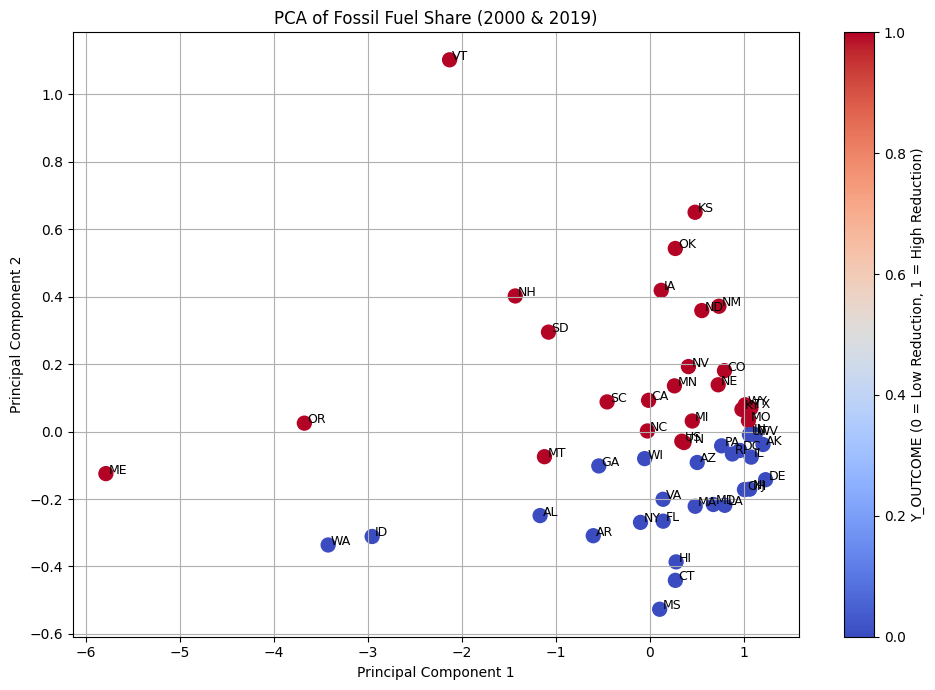

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# === Load your dataset ===
df = pd.read_csv("/preprocessed_fossil_reduction_2000_2019.csv")  # Update path if needed

# === Select features ===
features = ['fossil_share_2000', 'fossil_share_2019']
X = df[features]

# === Standardize the data ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Perform PCA ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# === Plot PCA results ===
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                      c=df['Y_OUTCOME'], cmap='coolwarm', s=100)

# Add state labels
for i, state in enumerate(df['State']):
    plt.text(X_pca[i, 0] + 0.03, X_pca[i, 1], state, fontsize=9)

# Axis labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Fossil Fuel Share (2000 & 2019)')
plt.grid(True)

# Colorbar for Y_OUTCOME
cbar = plt.colorbar(scatter)
cbar.set_label('Y_OUTCOME (0 = Low Reduction, 1 = High Reduction)')

plt.tight_layout()
plt.show()


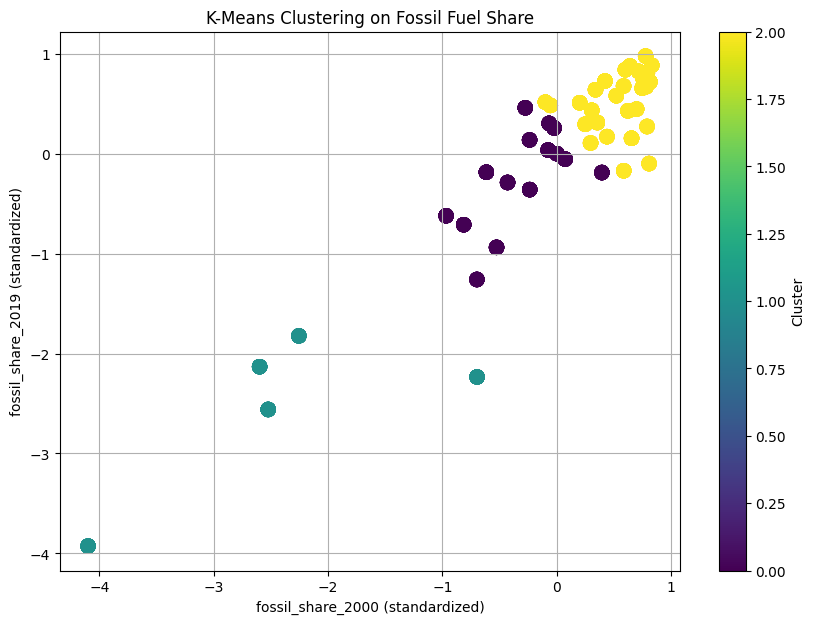

Cluster centers (standardized):
[[-0.30038641 -0.22593766]
 [-2.43518438 -2.53502147]
 [ 0.55605727  0.53547241]]


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("/df_merged.csv")

# === 1. Select features for clustering ===
features = ['fossil_share_2000', 'fossil_share_2019']
X = df[features]

# === 2. Standardize data ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 3. Choose number of clusters (k) ===
k = 3  # You can tune this using the elbow method

# === 4. Apply K-Means ===
kmeans = KMeans(n_clusters=k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# === 5. Plot the clusters ===
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1],
                      c=df['Cluster'], cmap='viridis', s=100)
plt.xlabel('fossil_share_2000 (standardized)')
plt.ylabel('fossil_share_2019 (standardized)')
plt.title('K-Means Clustering on Fossil Fuel Share')
plt.grid(True)
plt.colorbar(scatter, label='Cluster')
plt.show()

# Optional: Inspect cluster centers
print("Cluster centers (standardized):")
print(kmeans.cluster_centers_)


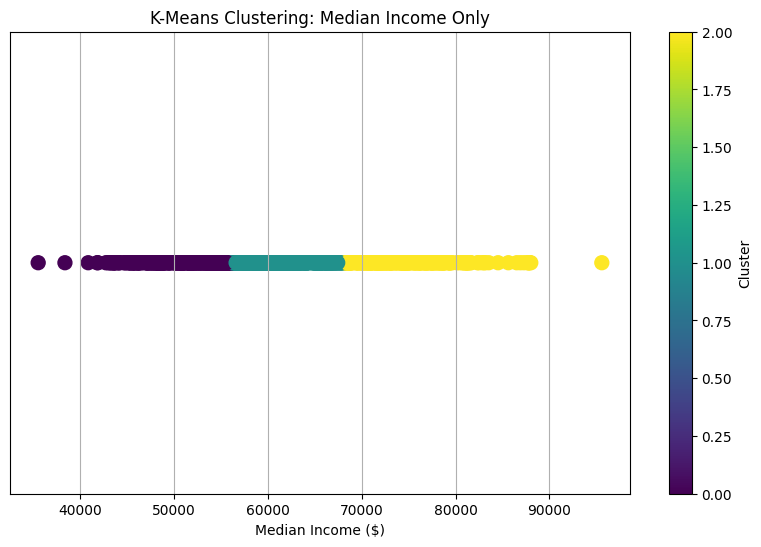

Cluster centers (Median Income in $):
[[50854.11641791]
 [61491.2673031 ]
 [74824.37398374]]


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# === 1. Load dataset ===
df = pd.read_csv("/df_merged.csv")  # Update path if needed

# === 2. Select only median income ===
X = df[['Median Income ($)']]

# === 3. Standardize ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 4. Apply K-Means ===
k = 3  # Choose number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
df['Income_Cluster'] = kmeans.fit_predict(X_scaled)

# === 5. Plot median income clusters ===
plt.figure(figsize=(10, 6))
plt.scatter(df['Median Income ($)'], [0]*len(df),
            c=df['Income_Cluster'], cmap='viridis', s=100)
plt.xlabel('Median Income ($)')
plt.yticks([])  # remove y-axis ticks
plt.title('K-Means Clustering: Median Income Only')
plt.grid(True)
plt.colorbar(label='Cluster')
plt.show()

# Optional: Check cluster centers (in original $ scale)
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
print("Cluster centers (Median Income in $):")
print(cluster_centers)


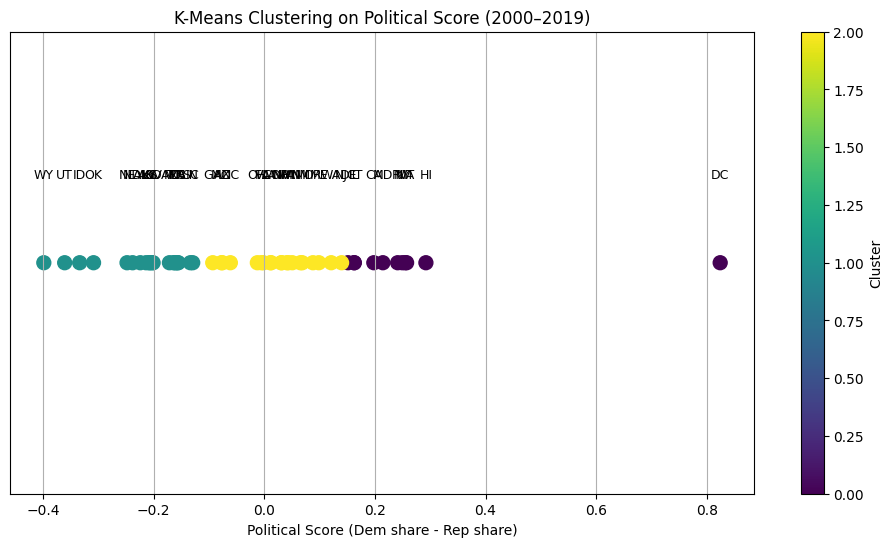

   state_po  political_score  Cluster
6        CT         0.162358        0
7        DC         0.824041        0
4        CA         0.198064        0
8        DE         0.151419        0
11       HI         0.292195        0
14       IL         0.162853        0
20       MD         0.214457        0
19       MA         0.254866        0
39       RI         0.241200        0
46       VT         0.257283        0
34       NY         0.249476        0
15       IN        -0.129296        1
16       KS        -0.206927        1
13       ID        -0.333523        1
2        AR        -0.171323        1
18       LA        -0.155316        1
28       ND        -0.237885        1
29       NE        -0.247934        1
26       MT        -0.164052        1
25       MS        -0.156544        1
36       OK        -0.308495        1
50       WY        -0.398343        1
49       WV        -0.202438        1
44       UT        -0.360649        1
43       TX        -0.161461        1
40       SC 

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# === 1. Load dataset ===
df = pd.read_csv("/1976-2020-president.csv")

# === 2. Filter for 2000–2019 and only Democrat/Republican ===
df_recent = df[(df['year'] >= 2000) & (df['year'] <= 2019)]
df_recent = df_recent[df_recent['party_simplified'].isin(['DEMOCRAT', 'REPUBLICAN'])]

# === 3. Get total votes per state/year ===
total_votes = df_recent.groupby(['state_po', 'year'])['totalvotes'].max().reset_index()

# === 4. Get party vote shares ===
party_votes = df_recent.groupby(['state_po', 'year', 'party_simplified'])['candidatevotes'].sum().reset_index()
party_votes = party_votes.merge(total_votes, on=['state_po', 'year'])
party_votes['vote_share'] = party_votes['candidatevotes'] / party_votes['totalvotes']

# === 5. Pivot to get Dem and Rep shares ===
pivot_votes = party_votes.pivot_table(index=['state_po', 'year'],
                                      columns='party_simplified',
                                      values='vote_share').reset_index()

# === 6. Calculate political score: Dem share - Rep share ===
pivot_votes['political_score'] = pivot_votes['DEMOCRAT'] - pivot_votes['REPUBLICAN']

# === 7. Average political score per state ===
state_scores = pivot_votes.groupby('state_po')['political_score'].mean().reset_index()

# === 8. Scale and apply K-Means ===
X = state_scores[['political_score']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
state_scores['Cluster'] = kmeans.fit_predict(X_scaled)

# === 9. Plot with labels ===
plt.figure(figsize=(12, 6))
scatter = plt.scatter(state_scores['political_score'], [0]*len(state_scores),
                      c=state_scores['Cluster'], cmap='viridis', s=100)

# Add state abbreviations
for i, row in state_scores.iterrows():
    plt.text(row['political_score'], 0.02, row['state_po'], fontsize=9, ha='center')

plt.xlabel('Political Score (Dem share - Rep share)')
plt.yticks([])
plt.title('K-Means Clustering on Political Score (2000–2019)')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

# === 10. (Optional) View cluster assignments ===
print(state_scores.sort_values('Cluster'))
